# Tweet Accessing, Preprocessing and Visualization  in Python

## Introduction

The use of social media worldwide has grown rapidly since its origins in the late 1990s. Between 2005 and 2015 the percentage of American adults who use social media grew from 7% to 65% [1]. As a result, the vast majority of the population influence and are influenced by the social media landscape. Each day millions of people post their opinions on politics, media, celebrities, health and business online on a number of platforms such as Facebook and Twitter. This provides a constant stream of new data for data scientists to access, process and analyze. These data can give insights into the public mood, be used to detect internet scams or be used to craft more effective marketing campaigns. 

In terms of data analysis, Twitter is a highly popular source of social media based data for industry and academia, despite only being the 8th most popular in terms of active users. This is largely because the infrastructure of Twitter is unlike any of the other social media's in terms of the ease of access, consistency of format and volume of data. Anybody with a computer can use Twitter APIs to access almost 100% of Twitter's data for free [2].


Once the data has been accessed and has undergone intital processing, it can be analysed in a number of different ways. Some popular analyses include:
- sentiment analysis: classifying tweets on a certain topic as positive, neutral or negative
- topic classification: using machine learning techniques to separate and classify tweets to certain topics
- social network analysis: graphing the relationships between users

[1] https://smallbiztrends.com/2013/05/the-complete-history-of-social-media-infographic.html

[2] http://blogs.lse.ac.uk/impactofsocialsciences/2017/05/08/using-twitter-as-a-data-source-an-overview-of-social-media-research-tools-updated-for-2017/

### Tutorial Content

In this tutorial we will do some basic Twitter scraping and preliminary analysis and visualization. This tutorial will make use of a number of libraries, with the focus being on Tweepy, TextBlob, Basemap and WordCloud.

This tutorial will cover the following topics, most of which relate to the early-stages of the data-science pipeline:
- [Installing the libraries](#Installing-the-libraries)
- [Setting up a Twitter application](#Setting-up-a-Twitter-application)
- [Streaming tweets](#Streaming-tweets)
- [Preprocessing and sentiment analysis](#Preprocessing-and-sentiment-analysis)
- [Visualizing geographical data](#Visualizing-geographical-data)
- [Graphical tweet visualization](#Graphical-tweet-visualization)
- [Visualizing textual frequency](#Visualizing-textual-frequency)


## Installing the libraries

Before getting started with the Twitter API, the libraries we will be using must be installed. This tutorial assumes that Anaconda with Python 3 is installed. If not, you can find instructions for installation [here](https://conda.io/docs/user-guide/install/index.html). Not using Anaconda would result in a great deal of libraries having to be installed, with some complexity.

First, the Tweepy, WordCloud, nltk and Basemap library can be installed with the commands:

    $ conda install -c conda-forge tweepy

    $ conda install -c conda-forge wordcloud
    
    $ conda install -c anaconda nltk
    
    $ conda install basemap

## Setting up a Twitter application

Before you can start accessing the Twitter APIs, you must make sure that you have a Twitter account (create one [here](https://twitter.com/signup?lang=en)). Once you have an account, you need to create an application on the website in order to get access keys for the API. A new application can be made [here](https://apps.twitter.com/app/new) once you are logged into your account. Fill in the form and create the application. Following this, navigate to the 'Keys and Access Tokens' tab and click 'Create my Access Token'. Then the Consumer Key, Consumer Secret, Access Token and Access Token Secret can be copied into your script.

Once this is done, access can be authorized using the tweepy library to access the Twitter RESTful API.

In [2]:
import tweepy
from wordcloud import WordCloud


In [3]:
# load in keys (these have not been given because they should be kept private)
consumerKey = "INSERT HERE"
consumerSecret = "INSERT HERE"
accessToken = "INSERT HERE"
accessSecret = "INSERT HERE"

# generate OAuthHandler instance by passing in the consumer key and secret
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessSecret)

#set up API interface
myAPI = tweepy.API(auth)

The RESTful API is the easiest to use of the Twitter APIs and pulls data from the Twitter databases. However, because the data is pulled from Twitter, there are serious limitations in the amount of data that can be accessed. Twitter only allows 180 requests per 15 minutes, which is not ideal for data science applications. Uses of the RESTful API include:
- Accessing user information (statuses, retweets, followers, friends, etc.)
- Managing (posting/obtaining/deleting) statuses, retweets, follwoers, direct messages, account details, etc.
- Viewing trends, finding geo-locations of interest

In [72]:
# Get user object, on which we will call some basic methods for demonstration
user = myAPI.get_user('realDonaldTrump')
print(user.screen_name+"'s follower count:", user.followers_count)
print(user.screen_name+"'s first 10 friends:")
for friend in user.friends(count=5):
    print(friend.screen_name)

# print the first 5 tweets on Trump's timeline
print()
print("Trump's timeline:")
for status in tweepy.Cursor(myAPI.user_timeline,id='realDonaldTrump').items(5):
    print(status.text)

realDonaldTrump's follower count: 49713301
realDonaldTrump's first 10 friends:
parscale
PressSec
TuckerCarlson
JesseBWatters
WhiteHouse

Trump's timeline:
Washington spent trillions building up foreign countries while allowing OUR OWN infrastructure to fall into a state… https://t.co/TkcOWOL5tf
JOBS, JOBS, JOBS! Unemployment claims have fallen to a 45-year low. Together, we are making the economy great again! https://t.co/pN2TE5HDQm
We are going to REBUILD our crumbling infrastructure, and there is no better place to begin this campaign than in t… https://t.co/5tbcDBRyqP
I have stated my concerns with Amazon long before the Election. Unlike others, they pay little or no taxes to state… https://t.co/ONyVYY2yMe
....In the interim, Hon. Robert Wilkie of DOD will serve as Acting Secretary. I am thankful for Dr. David Shulkin’s… https://t.co/YTgVqILsvk


## Streaming tweets

Twitter's Streaming API is far more useful in terms of data science, since Tweepy creates a connection with the API, which pushes large volumes of data. Thus large quantities of tweets can be collected.

In order to start streaming, you must make a class that inherits from Tweepy's StreamListener class. Within your defined class, you can decide how you want to process the incoming data in the on_data(self,data) function. In this implementation, the incoming data is stored in a .json file for later use. The init function can be edited so that the listener only processes data for a specified amount of time, as below.


In [132]:
import time
from tweepy.streaming import StreamListener

In [133]:
# build stream listener
class PDSListener(StreamListener):
    def __init__(self, writeFile, runTime=3):
        # initialise timer so that the stream processing runs for allotted time
        self.runTime = runTime
        self.startTime = time.time()
        self.currentTime = time.time()
        self.writeFile = writeFile
        super().__init__()
        
    #define function to process the tweet as desired:
    def on_data(self, data):
        self.currentTime=time.time()
        #break processing loop after allocated collection time
        if self.currentTime-self.startTime >= self.runTime:
            print("Harvest over.")
            return False # returning False stops the processing of data
        try:
            with open(self.writeFile,'a') as f:
                f.write(data)
                return True
        except BaseException as e: # used to catch errors in the stream without stopping the program
            print('Error: '+str(e))
            return True

Once the listener is defined, it can be instantiated and used to create a tweepy.Stream, which opens a connection with the Streaming API. The .filter() method filters out tweets not containing the keywords defined.

In [6]:
scandalListener = PDSListener('scandalABC.json', 3600) # collect tweets for 1 hour
scandalStream = tweepy.Stream(auth=auth, listener=scandalListener) # open a stream using your defined listener class
scandalKeyWords= ['scandalABC'] 
scandalStream.filter(track=scandalKeyWords, async=True) # filter according to whatever keywords are of interest to you

Harvest over.


In [31]:
trumpListener = PDSListener('tweetsTrump.json', 3600)
trumpStream = tweepy.Stream(auth=auth, listener=trumpListener)
trumpKeyWords= ['trump', 'donald trump', 'president trump']
trumpStream.filter(track=trumpKeyWords, async=True)

## Preprocessing and sentiment analysis

Once the data has been collected, it is important to do some initial preprocessing, so that the data is properly formatted and easy to use. 

In the functions defined below, the data is processed by retaining only tweets where a significant amount of data is available. The coordinates of the tweet location (if available) are extracted, and a basic sentiment analysis using TextBlob is performed.

TextBlob is a textual data processing library that builds upon the 'nltk' and 'patterns' libraries to provide tools for noun-phrase tagging and sentiment analysis, among other things. The sentiment analysis feature of TextBlob provides two metrics: sentiment and subjectivity. Sentiment ranges from -1 (negative sentiment) to +1 (positive sentiment), whilst subjectivity ranges from 0 (highly objective) to 1 (highly subjective).


In [110]:
import pandas as pd
import re
from textblob import TextBlob
import string

In [111]:
scandalTweets = pd.read_json('scandalABC.json', lines=True) # convert json file into pandas Dataframe for processing
trumpTweets = pd.read_json('tweetsTrump.json', lines=True)

In [119]:
def initialProcess(df):
    df = df.dropna(axis=0, how='any', thresh = 4) # remove useless results
    senti = list(map(sentiTweet, df.text))
    df['senti']= pd.Series(senti, index=df.index) # calculate general sentiment for each tweet
    latlon = []
    for index, row in df.iterrows():
        if row.place != None:
            latlon.append(row.place['bounding_box']['coordinates'][0][0]) # find approximate location of tweet
        else:
            latlon.append(None)
    df['latlon']=pd.Series(latlon, index=df.index) # store latitude and longitude of each tweet
    return df

def sentiTweet(text):
    tweet = " ".join(re.findall("[a-zA-Z]+", text)) # analyze on only alphabetic characters
    tweetBlob = TextBlob(tweet.strip()) # create TextBlob object based on tweet
    senti = 0
    sentCount = 0
    for sent in tweetBlob.sentences: # TextBlob calculates sentiment per sentence in a text, so must sum all sentences
        senti += sent.sentiment.polarity
    return senti

def processTweets(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    tweets = list()
    for index, row in df.iterrows():
        if isinstance(row.text, str):
            text= row.text
            for i in range(len(row.entities['urls'])): # remove urls
                text = text.replace(row.entities['urls'][i]['display_url'],'') # remove displayed urls
            for mention in row.entities['user_mentions']: # remove twitter handles
                text= text.replace(mention['screen_name'],'') 
            for hashtag in row.entities['hashtags']: # remove hashtags
                text.replace(hashtag['text'],'')
            for punc in string.punctuation:
                text = text.replace(punc, "")
            text = text.lower().replace("'s", "").replace("'","") # remove apostrophes and instances of 's
            wordTokens = nltk.word_tokenize(text)
            lemmatizedTokens = list()
            for token in wordTokens:
                try:
                    lemmatizedToken = lemmatizer.lemmatize(token)
                    lemmatizedTokens.append(lemmatizedToken)
                except:
                    pass
            text = ' '.join(lemmatizedTokens)
            tweets.append(text)
    return tweets

In [118]:
# perform preprocessing of tweets
scandalFilt = initialProcess(scandalTweets)
trumpFilt = initialProcess(trumpTweets)

## Visualizing geographical data

Basemap, while not being explicitly related to Twitter, is a very useful tool for visualizing geographical data from tweets that is worth mentioning. It is a great tool for visualizing data prior to diving deep into numerical analysis.

In order to create a map, the bottom left and upper right coordinates of the map are required. These can be found for any map you wish using [this website](http://boundingbox.klokantech.com). At this site is a global map. Navigate the bounding box into whatever quadrant of the globe you desire, then seek the drop down menu at the bottom left-hand corner and change this to 'DublinCore'. Once this is selected, the coordinates should appear in the field to its right, in the format 'westlimit=-169.2; southlimit=12.2; eastlimit=-49.9; northlimit=74.1'.

Once the coordinates have been obtained, a map can be created using the Basemap function, with the imports as given. It is well-advised to draw the map at first with crude resolution, 'c'. Once the map is finalised, the resolution can be increased, by populating the resolution field of Basemap with one of the following codes (in increasing quality): c, l, i, h, f. Once the basemap is created, geographic data can be plotted using the basemap.plot() method.


In [108]:
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


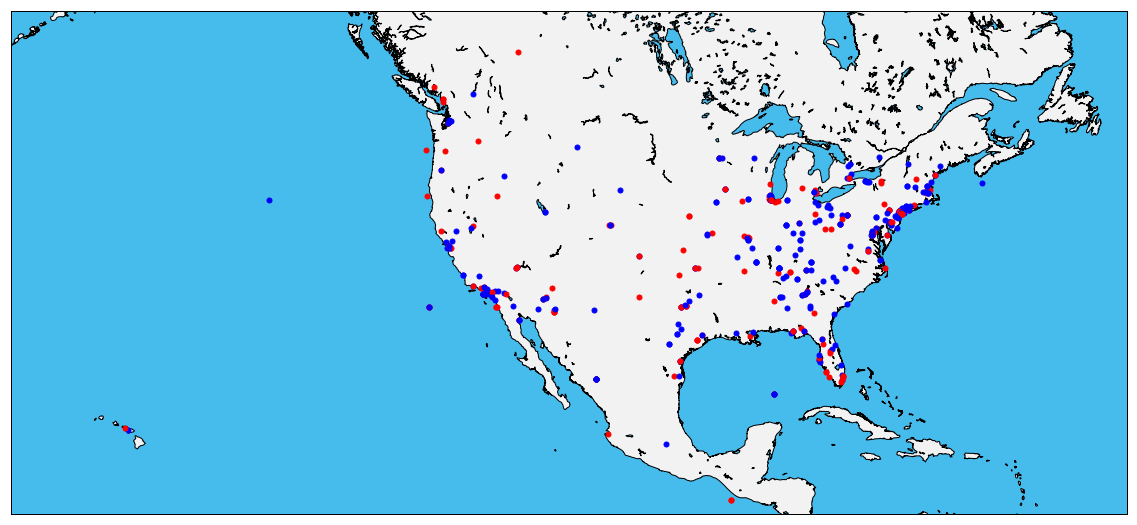

Number of points: 520  Number of usable tweets: 109105  Percent of tweets plotted: 0.48
Number of positive points:  337 Number of negative points: 183


In [122]:
# Website format: westlimit=-169.2; southlimit=12.2; eastlimit=-49.9; northlimit=55.0
# Equivalent to: llcrnrlon=-169.2, llcrnrlat=12.2, urcrnrlon=-49.9, urcrnrlat=55.0
fig= plt.subplots(figsize=(20,10))
# use resolution= 'c' (crude) when playing with the map, then increase resolution when its complete
usMap = Basemap(resolution = 'i', # intermediate quality rendering
                projection = 'merc', # mercator projection-type map
                llcrnrlon=-169.2, llcrnrlat=12.2, urcrnrlon=-49.9, urcrnrlat=55.0)
usMap.drawmapboundary(fill_color='#46bcec') # fill in oceans as blue
usMap.fillcontinents(color='#f2f2f2', lake_color='#46bcec') # fill land in grey, lakes in same color as oceans
usMap.drawcoastlines() # draws coastlines

positiveCount = 0
negativeCount = 0
for index, row in trumpFilt.iterrows():
    if row.latlon != None:
        lat = row.latlon[0]
        lon = row.latlon[1]
        if row.senti>0: 
            # plots blue points for positive sentiment tweets
            usMap.plot(lat, lon, 'bo', markersize=5, latlon=True) 
            # latlon=True allows the input plot coordinates to be global
            positiveCount+=1
        elif row.senti<0: 
            # plots red points for negative sentiment tweets
            usMap.plot(lat, lon, 'ro', markersize=5, latlon=True)
            negativeCount+=1
pointCount = positiveCount + negativeCount
plt.show() # display map

print('Number of points: %d  Number of usable tweets: %d  Percent of tweets plotted: %0.2f' % 
      (pointCount, len(trumpFilt), 100*pointCount/len(trumpFilt)))
print("Number of positive points: ", positiveCount, 'Number of negative points:', negativeCount)

## Graphical tweet visualization

It is clear from the map above that there are serious limitations to twitter data visualizations in geographic form. Many Twitter users keep their geographical locations private, so most twitter data is off-limits in terms of geographic analysis. For geographical plots like these, a much larger data set is needed, which can simply be gathered by streaming for a longer period of time. In fact, inside the Listener class, you could filter the tweets collected based on whether or not they had any geo-tag.

In light of this limitation in our dataset, we will apply some other forms of visualization and analysis on the whole gathered dataset. Below we plot a simple histogram of tweet sentiment for the Trump dataset, for reasons that will soon become obvious.

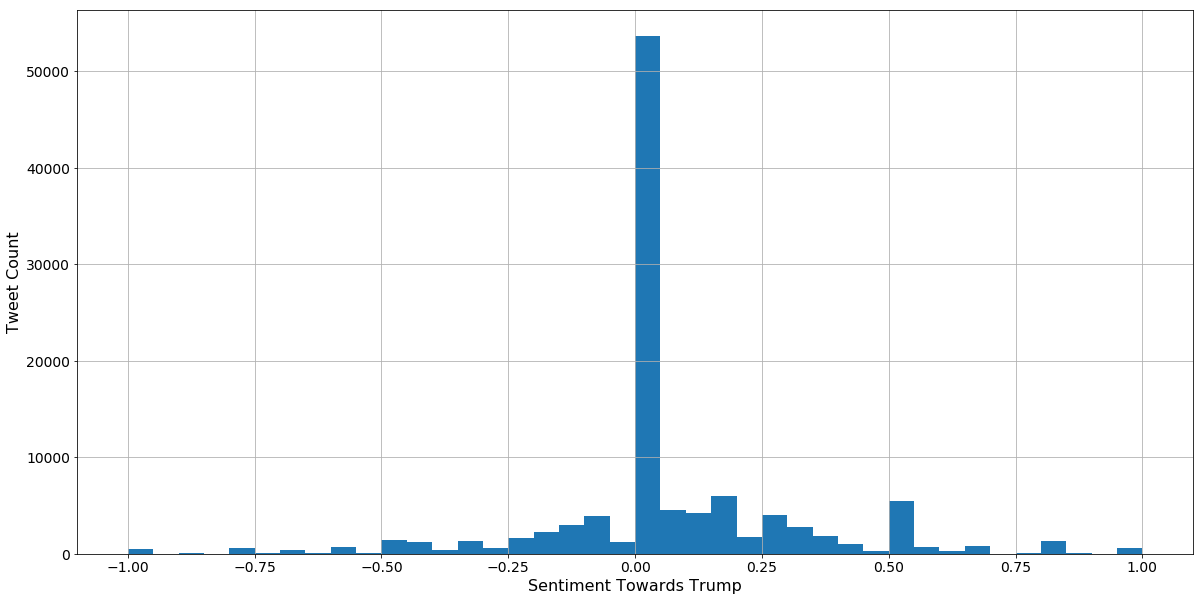

In [121]:
plt.figure(figsize=(20,10)) # set figure size
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.xlabel("Sentiment Towards Trump", fontsize=16) # set labels
plt.ylabel("Tweet Count", fontsize=16)
y,x,_ = plt.hist(trumpFilt.senti, bins=40); # plot histogram
ax.grid(which='both')
plt.show()

Histograms can give a telling insight into tweet data, especially when sentiment analysis is run on each tweet. For instance, the above histogram shows that the sentiment in tweets mentioning trump is largely in the slightly negative to slightly positive range. The large bar illustrates that roughly half of all tweets show no or near-to-no emotional sentiment. Generally speaking, a more pronounced bell-curve would be expected if the sentiment analyzer is well-calibrated to the dataset. This is the downside to using a general library such as TextBlob, and for more rigorous applications it is important to train your own sentiment analyzer on a labeled dataset.

When it comes to Twitter analysis, another important feature is the rate of tweeting. For instance, using the PDSListener, I gathered tweets on the topic of 'scandalABC', a popular television show on the ABC network. Using the timestamps of each tweet (stored the 'created_at' field), interesting features can be observed.

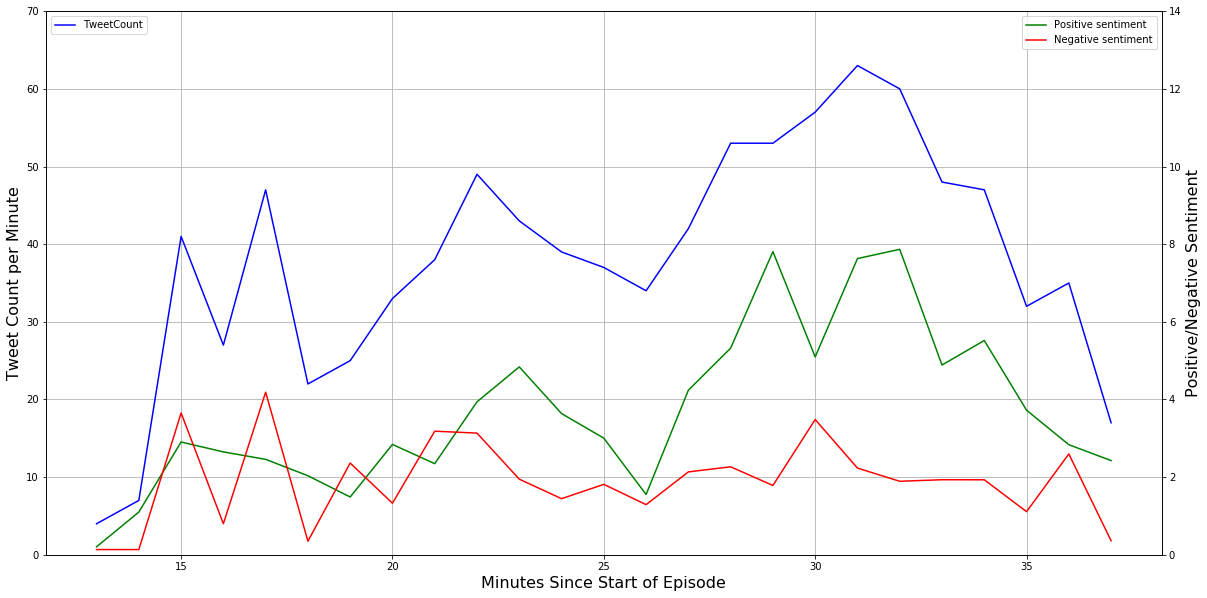

In [127]:
times = scandalFilt.created_at
tweetTimes = [row.minute for row in times]
tweetSentiment = list(scandalFilt.senti)
mins, counts, posSentiment, negSentiment = [], [], [], []
previous = -1
for i in range(len(tweetTimes)):
    if tweetTimes[i] != previous: # gather minute-by-minute information
        mins.append(tweetTimes[i])
        counts.append(0)
        posSentiment.append(0)
        negSentiment.append(0)
    counts[-1] +=1
    if tweetSentiment[i] >= 0:
        posSentiment[-1] +=tweetSentiment[i] # calculate the sum of tweet positivity at each minute
    else:
        negSentiment[-1] -=tweetSentiment[i] # calculate the sum of tweet negativity at each minute
    previous=myTimes[i]
    
# plot time-based data
plt.figure(figsize=(20,10)) # set figure size
ax1 = plt.subplot(111)
ax2 = ax1.twinx() # create second axis
ax1.plot(mins,counts, 'b', label='TweetCount') #label lines
ax2.plot(mins, posSentiment, 'g', label='Positive sentiment')
ax2.plot(mins, negSentiment, 'r', label='Negative sentiment')
ax1.set_ylim(0,70)
ax1.set_ylabel('Tweet Count per Minute', fontsize = 16) #label axes
ax2.set_ylim(0,14)
ax2.set_ylabel('Positive/Negative Sentiment', fontsize=16)
ax1.legend(loc=2) # create plot legend
ax2.legend(loc=1)
ax1.set_xlabel('Minutes Since Start of Episode', fontsize = 16)
ax1.grid() # add grid to plot
plt.show() # display plot

When an important event is occurring, there tends to be a spike in the number of tweets. For instance, in the last episode of Scandal to air, around the 30-34 minute marks, there is a clear bump in the rate of tweeting about the show, corresponding to a dramatic scene. Note that the dataset does not run for the entire length of the episode, due to some personal technical difficulties.

## Visualizing textual frequency

Another interesting way to visualize tweets is in what is known as a term frequency cloud. This visualization tool illustrates the relative frequencies of the most common words in a piece of text as the relative size of the words in the word cloud. Whilst this is not of major use to data scientists, such forms of data visualization can be very useful for illustrating textual data to the layman, or to non-technical management in the workplace. As such, they are a valuable tool.

In order to create such word clouds for tweets, it is important to first process the tweet text. WordCloud takes a single file or string as an input, so first we must process (to remove urls and twitter handles for example) the tweets, then concatenate them. The concatenated text is passed into the WordCloud function, then the wordcloud is plotted using the plt.imshow method. The WordCloud function also takes a stopwords parameter, where common words that we do not want to display can be ommitted. These will vary from application and can be easily determined by first creating a wordcloud without stopwords.

In [131]:
from wordcloud import WordCloud
import nltk

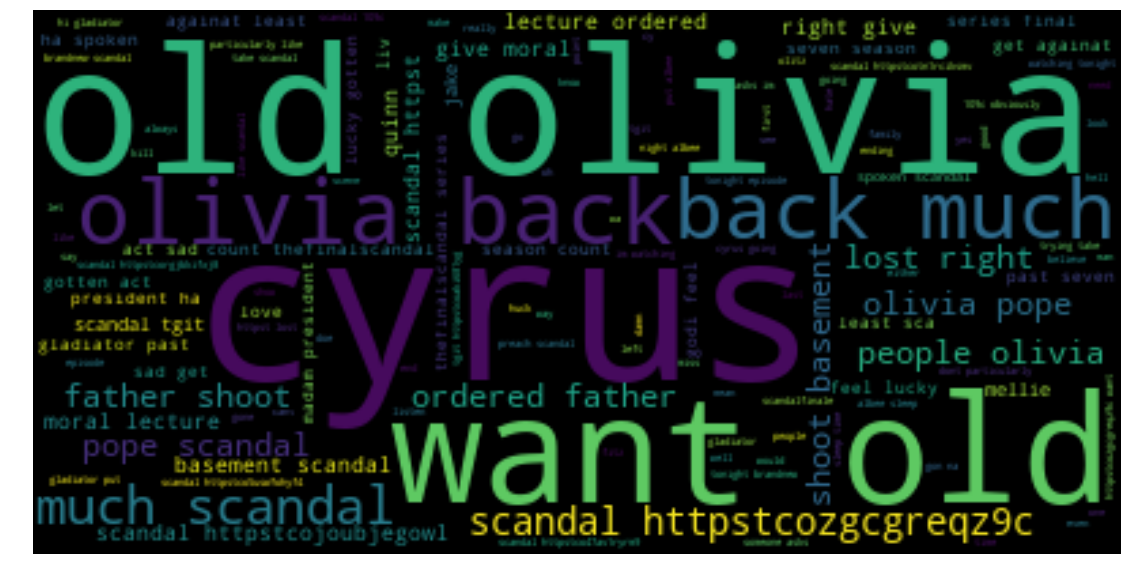

In [134]:
scandalTweetList = processTweets(scandalFilt)
scandalString = ' '.join(scandalTweetList)
# input generic english stopwords, alongside Twitter specific ones
stopWords = ['rt', 'amp', 'scandalabc']+nltk.corpus.stopwords.words('english')
# generate word cloud based off input string
scandalWordCloud = WordCloud(stopwords=stopWords).generate(scandalString) 
# plot word cloud
fig= plt.subplots(figsize=(20,10))
plt.imshow(scandalWordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Summary and references

This tutorial highlighted the basic use of the Twitter APIs using Tweepy, along with some basic pre-processing and visualization techniques. The aim of this tutorial was to give a quick snapshot of the countless opportunities for data analysis that Twitter data offers with the hope that the reader is ready to explore further down the data science pipeline and begin to apply machine learning methods to obtain useful insight from the data.

Much greater detail on the libraries used here and questions about using Twitter data are available at the following links:
- Twitter APIs: https://developer.twitter.com/en/docs
- Tweepy: http://docs.tweepy.org/en/v3.5.0/
- TextBlob: http://textblob.readthedocs.io/en/dev/#
- BaseMap: https://basemaptutorial.readthedocs.io
- WordCloud: https://amueller.github.io/word_cloud/
